# Metrics Aggregation by Experiment
This notebook aggregates metrics from all_metrics.csv by experiment name,
showing mean and standard deviation for coverage, mutation score, and tokens used.

# Graphs for the report

## Comparing the single agents

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]

# Filter Single Agents
df_single = df[df["experiment_name"].str.startswith("single_")].copy()

# Calculate Metrics
df_single["total_tests"] = df_single["n_passed_tests"] + df_single["n_failed_tests"]
df_single["pass_rate"] = df_single.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# Aggregate
metrics = ["pass_rate", "coverage_percent", "mutation_score_percent"]
agg_df = df_single.groupby("experiment_name")[metrics].mean().reset_index()

# Clean Names
agg_df["experiment_name"] = agg_df["experiment_name"].str.replace("single_", "")

# Normalize data for Parallel Coordinates (0-1 Scale)
scaler = MinMaxScaler()
df_norm = agg_df.copy()
df_norm[metrics] = scaler.fit_transform(agg_df[metrics])

# Rename columns for the plot
df_norm.columns = ["Agent", "Pass Rate", "Coverage", "Mutation Score"]

# Melt for plotting
df_melted = pd.melt(
    df_norm, id_vars="Agent", var_name="Metric", value_name="NormalizedScore"
)

# Plotting Parallel Coordinates Style using Lineplot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Draw the lines
sns.lineplot(
    data=df_melted,
    x="Metric",
    y="NormalizedScore",
    hue="Agent",
    palette="viridis",
    linewidth=3,
    marker="o",
    markersize=8,
)

# Formatting
plt.title("Qualitative Comparison (Single Agents)", fontsize=16)
plt.ylabel("Relative Score (0=Worst, 1=Best)", fontsize=12)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, axis="x", linestyle="--")

plt.tight_layout()
os.makedirs("report", exist_ok=True)
# plt.savefig("report/parallel_coordinates_quality_only.png")

## Baseline vs collaborative vs competitive

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]

# Consistent color palette across charts
ARCH_COLORS = {
    "Single Agent": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Competitive": "#ff7f0e",
}
BASELINE_COLORS = {
    "Best Single": "#1f77b4",
    "Avg Single": "#aec7e8",
}


# 1. Categorize experiments
def get_category(name):
    if name.startswith("single_"):
        return "Single Agent"
    elif name.startswith("collaborative_"):
        return "Collaborative"
    elif name.startswith("competitive_"):
        return "Competitive"
    return "Other"


df["category"] = df["experiment_name"].apply(get_category)

# 2. Calculate Metrics
df["total_tests"] = df["n_passed_tests"] + df["n_failed_tests"]
df["pass_rate"] = df.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# 3. Prepare Data for Multi-Agent (Collaborative & Competitive)
multi_agent_df = df[df["category"].isin(["Collaborative", "Competitive"])]

# 4. Prepare Data for Baselines
# Baseline 1: Best Single Agent (gptoss120B)
best_baseline_df = df[df["experiment_name"] == "single_gptoss120B"]
best_baseline_means = best_baseline_df[
    ["pass_rate", "coverage_percent", "mutation_score_percent"]
].mean()

# Baseline 2: Average of All Single Agents
avg_baseline_df = df[df["category"] == "Single Agent"]
avg_baseline_means = avg_baseline_df[
    ["pass_rate", "coverage_percent", "mutation_score_percent"]
].mean()

# 5. Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Architecture Comparison: Multi-Agent vs Baselines", fontsize=16)

metrics = [
    ("pass_rate", "Pass Rate (%)", 85, 101),
    ("coverage_percent", "Coverage (%)", 85, 101),
    ("mutation_score_percent", "Mutation Score (%)", 60, 80),
]

categories = ["Collaborative", "Competitive"]
colors = [ARCH_COLORS["Collaborative"], ARCH_COLORS["Competitive"]]

for i, (metric, title, ylim_min, ylim_max) in enumerate(metrics):
    ax = axes[i]

    # Baseline Values
    best_val = best_baseline_means[metric]
    avg_val = avg_baseline_means[metric]

    # Plot Bars with seaborn for confidence intervals
    sns.barplot(
        data=multi_agent_df,
        x="category",
        y=metric,
        hue="category",
        order=categories,
        hue_order=categories,
        palette=colors,
        ax=ax,
        errorbar=("ci", 95),
        capsize=0.1,
        alpha=0.8,
        legend=False,
    )

    # Plot Baseline Lines
    # Line 1: Best Baseline
    ax.axhline(
        y=best_val,
        color=BASELINE_COLORS["Best Single"],
        linestyle="--",
        linewidth=2,
        label=f"Best Single Agent: {best_val:.1f}%",
    )

    # Line 2: Average Baseline
    ax.axhline(
        y=avg_val,
        color=BASELINE_COLORS["Avg Single"],
        linestyle=":",
        linewidth=2,
        label=f"Avg Single Agent: {avg_val:.1f}%",
    )

    # Styling
    ax.set_title(title, fontsize=14)
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_ylabel("Score (%)")
    ax.set_xlabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Legend
    ax.legend(loc="lower center", fontsize=9)

plt.tight_layout()
# plt.savefig("report/multi_agent_vs_baselines_bars.png")

## Big vs mixed vs small (vs collaborative vs competitive vs single)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]

# Consistent color palette across charts
ARCH_COLORS = {
    "Single Agent": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Competitive": "#ff7f0e",
}

# --- 1. Data Preparation & Classification ---

# Define Model Sizes
big_models = ["gptoss120B", "llama70B", "llama70b"]
small_models = [
    "llamascout17B",
    "llama8B",
    "gptoss20B",
    "llamascout17b",
    "gptoss20b",
]


def classify_experiment(exp_name):
    parts = exp_name.split("_")
    arch_type = parts[0]
    models = parts[1:]

    # 1. Architecture
    if arch_type == "single":
        return "Single Agent", None
    elif arch_type == "collaborative":
        architecture = "Collaborative"
    elif arch_type == "competitive":
        architecture = "Competitive"
    else:
        return "Other", None

    # 2. Composition
    has_big = False
    has_small = False

    for model in models:
        m_lower = model.lower()
        is_big = any(b.lower() in m_lower for b in big_models)
        is_small = any(s.lower() in m_lower for s in small_models)

        if is_big:
            has_big = True
        if is_small:
            has_small = True

    if has_big and not has_small:
        composition = "Big Only"
    elif has_small and not has_big:
        composition = "Small Only"
    elif has_big and has_small:
        composition = "Mixed (Big + Small)"
    else:
        composition = "Unknown"

    return architecture, composition


# Apply classification
df["Architecture"], df["Composition"] = zip(
    *df["experiment_name"].apply(classify_experiment)
)

# Metrics Calculation
df["total_tests"] = df["n_passed_tests"] + df["n_failed_tests"]
df["pass_rate"] = df.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# Rename for plotting
df = df.rename(
    columns={
        "pass_rate": "Pass Rate",
        "coverage_percent": "Coverage",
        "mutation_score_percent": "Mutation Score",
    }
)

metrics_list = ["Pass Rate", "Coverage", "Mutation Score"]

# --- 2. Calculate Baselines ---

# Best Single Agent (gptoss120B)
best_single_df = df[df["experiment_name"] == "single_gptoss120B"]
best_baselines = best_single_df[metrics_list].mean()

# Average Single Agent
avg_single_df = df[df["Architecture"] == "Single Agent"]
avg_baselines = avg_single_df[metrics_list].mean()

# --- 3. Filter Data for Plotting ---
# Keep only Multi-Agent rows with valid composition
plot_df = df[
    (df["Architecture"].isin(["Collaborative", "Competitive"]))
    & (df["Composition"] != "Unknown")
]

# --- 4. Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle(
    "Impact of Architecture & Model Size: Collaborative vs Competitive", fontsize=18
)

# Order for X-axis
comp_order = ["Big Only", "Mixed (Big + Small)", "Small Only"]
# Colors for Architecture
arch_palette = {
    "Collaborative": ARCH_COLORS["Collaborative"],
    "Competitive": ARCH_COLORS["Competitive"],
}

for i, metric in enumerate(metrics_list):
    ax = axes[i]

    # Plot Bar Chart
    sns.barplot(
        data=plot_df,
        x="Composition",
        y=metric,
        hue="Architecture",
        order=comp_order,
        hue_order=["Collaborative", "Competitive"],
        palette=arch_palette,
        ax=ax,
        errorbar=("ci", 95),  # Confidence Interval
        capsize=0.1,
    )

    # Add Baselines
    # Best Single
    ax.axhline(
        y=best_baselines[metric],
        color=ARCH_COLORS["Single Agent"],
        linestyle="--",
        linewidth=2,
        label=f"Best Single Agent",
    )
    # Avg Single
    ax.axhline(
        y=avg_baselines[metric],
        color="#aec7e8",
        linestyle=":",
        linewidth=2,
        label=f"Avg Single Agent",
    )

    # Styling
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Score (%)" if i == 0 else "")

    # Y-Limits adjustment to make room for text/visuals
    if metric == "Pass Rate" or metric == "Coverage":
        ax.set_ylim(90, 101)
    else:  # Mutation Score
        ax.set_ylim(60, 85)

    ax.grid(axis="y", linestyle="--", alpha=0.3)

    # Legend handling: Only show in the last plot or bottom
    if i == 1:  # Center legend for shared info? Or just put it in the last one.
        # Let's put legend in the middle plot, below
        pass

    # Remove individual legends to create a unified one later or keep per plot if clean
    ax.legend().remove()

# Unified Legend
# Get handles/labels from one of the axes
handles, labels = axes[0].get_legend_handles_labels()
# Add baseline handles manually if not in barplot handles (axhline doesn't automatically add to seaborn legend usually, need to check)
# Actually, axhline labels are in ax.get_legend_handles_labels() if labeled.
h, l = axes[0].get_legend_handles_labels()
# h contains bars + lines.
# h[0:2] are bars, h[2:4] are lines usually.

fig.legend(
    h,
    l,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=4,
    fontsize=12,
    frameon=False,
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make space for legend
# plt.savefig("report/architecture_size_comparison_split.png")

## Efficiency

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]

# Consistent color palette across charts
ARCH_COLORS = {
    "Single Agent": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Competitive": "#ff7f0e",
}
EFFICIENCY_COLORS = {
    "Average": "#95a5a6",
    "Best": ARCH_COLORS["Single Agent"],
}

# 2. Metric Calculation
# Pass Rate
df["total_tests"] = df["n_passed_tests"] + df["n_failed_tests"]
df["pass_rate"] = df.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] if row["total_tests"] > 0 else 0
    ),
    axis=1,
)

# File-Normalized Tokens (Relative Cost)
file_mean_tokens = df.groupby("file")["total_tokens"].transform("mean")
df["tokens_relative_cost"] = df["total_tokens"] / file_mean_tokens

# Relative Efficiency Score = (Quality / Cost)
# Quality = PassRate * Coverage * Mutation
# Cost = Normalized Tokens
df["efficiency"] = (
    df["pass_rate"]
    * df["coverage_percent"]
    * df["mutation_score_percent"]
    / df["tokens_relative_cost"]
)

# 3. Data Preparation for "Average" vs "Best" Comparison
categories = ["Single Agent", "Collaborative", "Competitive"]
plot_data = []


def get_category(name):
    if name.startswith("single_"):
        return "Single Agent"
    if name.startswith("collaborative_"):
        return "Collaborative"
    if name.startswith("competitive_"):
        return "Competitive"
    return "Other"


df["category"] = df["experiment_name"].apply(get_category)

combined_rows = []
for cat in categories:
    cat_df = df[df["category"] == cat]

    # "Average" Group: All runs in this category
    avg_rows = cat_df.copy()
    avg_rows["Condition"] = "Average"
    avg_rows["Architecture"] = cat
    combined_rows.append(avg_rows[["Architecture", "Condition", "efficiency"]])

    # "Best" Group: Runs from the single best experiment (highest mean efficiency)
    exp_means = cat_df.groupby("experiment_name")["efficiency"].mean()
    best_exp_name = exp_means.idxmax()
    best_rows = cat_df[cat_df["experiment_name"] == best_exp_name].copy()
    best_rows["Condition"] = "Best"
    best_rows["Architecture"] = cat
    combined_rows.append(best_rows[["Architecture", "Condition", "efficiency"]])

final_plot_df = pd.concat(combined_rows)

# 4. Plotting
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
palette = {"Average": EFFICIENCY_COLORS["Average"], "Best": EFFICIENCY_COLORS["Best"]}

ax = sns.barplot(
    data=final_plot_df,
    x="Architecture",
    y="efficiency",
    hue="Condition",
    palette=palette,
    errorbar=("ci", 95),  # Confidence Interval
    capsize=0.1,
)


plt.title(
    "Efficiency Analysis: Average vs Best Configuration per Architecture", fontsize=16
)
plt.ylabel("Relative Efficiency Score\n(Quality / Relative Cost)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.legend(title="Configuration")
plt.tight_layout()
# plt.savefig("report/efficiency_final.png")
plt.show()

In [ ]:
# Aggregate Single Agent Llama 8B by Temperature
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] == "success"]

# Filter Single Agent Llama 8B runs
df_llama8b = df[
    df["experiment_name"].str.contains("ablative_single_llama8B", na=False)
].copy()

# Calculate Metrics
df_llama8b["total_tests"] = df_llama8b["n_passed_tests"] + df_llama8b["n_failed_tests"]
df_llama8b["pass_rate"] = df_llama8b.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# Group by temperature and aggregate
metrics = [
    "pass_rate",
    "coverage_percent",
    "mutation_score_percent",
    "total_tokens",
    "iterations",
]
agg_by_temp = df_llama8b.groupby("temperature")[metrics].mean().reset_index()

# Display aggregated data
print("Temperature Sensitivity Analysis: Single Agent Llama 8B")
print("=" * 80)
print(agg_by_temp.to_string(index=False))
print("\n")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    "Temperature Sensitivity Analysis: Single Agent Llama 8B",
    fontsize=16,
    fontweight="bold",
)

# Plot 1: Pass Rate
axes[0, 0].plot(
    agg_by_temp["temperature"],
    agg_by_temp["pass_rate"],
    marker="o",
    linewidth=2,
    markersize=8,
    color="#2E86AB",
)
axes[0, 0].set_xlabel("Temperature", fontsize=11)
axes[0, 0].set_ylabel("Pass Rate (%)", fontsize=11)
axes[0, 0].set_title("Pass Rate", fontsize=12, fontweight="bold")
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Coverage
axes[0, 1].plot(
    agg_by_temp["temperature"],
    agg_by_temp["coverage_percent"],
    marker="s",
    linewidth=2,
    markersize=8,
    color="#A23B72",
)
axes[0, 1].set_xlabel("Temperature", fontsize=11)
axes[0, 1].set_ylabel("Coverage (%)", fontsize=11)
axes[0, 1].set_title("Coverage", fontsize=12, fontweight="bold")
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Mutation Score
axes[1, 0].plot(
    agg_by_temp["temperature"],
    agg_by_temp["mutation_score_percent"],
    marker="^",
    linewidth=2,
    markersize=8,
    color="#F18F01",
)
axes[1, 0].set_xlabel("Temperature", fontsize=11)
axes[1, 0].set_ylabel("Mutation Score (%)", fontsize=11)
axes[1, 0].set_title("Mutation Score", fontsize=12, fontweight="bold")
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Total Tokens
axes[1, 1].plot(
    agg_by_temp["temperature"],
    agg_by_temp["total_tokens"],
    marker="d",
    linewidth=2,
    markersize=8,
    color="#06A77D",
)
axes[1, 1].set_xlabel("Temperature", fontsize=11)
axes[1, 1].set_ylabel("Total Tokens", fontsize=11)
axes[1, 1].set_title("Total Tokens Used", fontsize=12, fontweight="bold")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Collaborative vs Collaborative Var vs Competitive

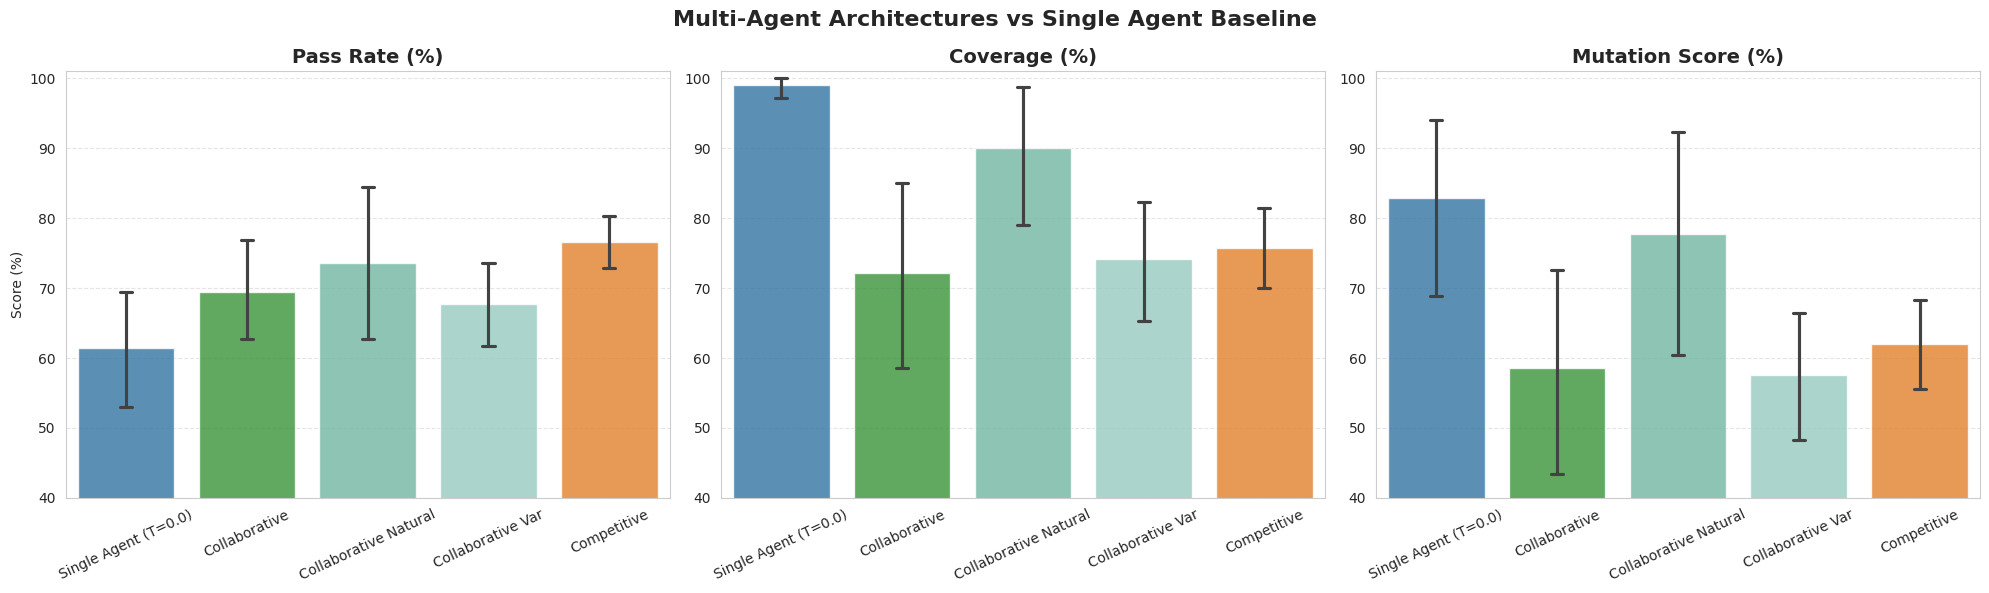


Summary Statistics:
                      pass_rate              coverage_percent               \
                           mean    std count             mean    std count   
Category                                                                     
Collaborative             69.51  22.98    36            72.17  40.62    36   
Collaborative Natural     73.53  24.20    20            90.00  23.12    20   
Collaborative Var         67.75  29.34    89            74.21  41.34    89   
Competitive               76.58  27.11   190            75.72  40.43   190   
Single Agent (T=0.0)      61.42  18.59    19            99.05   4.13    19   

                      mutation_score_percent               
                                        mean    std count  
Category                                                   
Collaborative                          58.51  43.95    36  
Collaborative Natural                  77.72  36.82    20  
Collaborative Var                      57.52  44.22   

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] == "success"]

# Filter experiments: collaborative, collaborative_var, competitive, and single llama8B T=0.0
df_filtered = df[
    df["experiment_name"].str.contains(
        "collaborative_llama8B|competitive_llama8B|single_llama8B_t=0.0",
        regex=True,
        na=False,
    )
].copy()

# Filter out entries with failed tests (keep only n_failed_tests == 0)
# df_filtered = df_filtered[df_filtered["n_failed_tests"] == 0]

# Calculate Pass Rate
df_filtered["total_tests"] = (
    df_filtered["n_passed_tests"] + df_filtered["n_failed_tests"]
)
df_filtered["pass_rate"] = df_filtered.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)


# Create Category Labels
def categorize_experiment(exp_name):
    if (
        "ablative_single_llama8B_t=0.0" in exp_name
        or "single_llama8B_t=0.0" in exp_name
    ):
        return "Single Agent (T=0.0)"
    elif "collaborative_llama8B_natural" in exp_name:
        return "Collaborative Natural"
    elif (
        "collaborative_llama8B_json_var" in exp_name
        or "collaborative_llama8B_var" in exp_name
    ):
        return "Collaborative Var"
    elif "collaborative_llama8B_json" in exp_name or (
        "collaborative_llama8B" in exp_name
        and "_json" not in exp_name
        and "_natural" not in exp_name
        and "_var" not in exp_name
    ):
        return "Collaborative"
    elif "competitive_llama8B_natural" in exp_name:
        return "Competitive Natural"
    elif "competitive_llama8B_json" in exp_name or (
        "competitive_llama8B" in exp_name
        and "_json" not in exp_name
        and "_natural" not in exp_name
    ):
        return "Competitive"
    return "Other"


df_filtered["Category"] = df_filtered["experiment_name"].apply(categorize_experiment)

# Remove any "Other" category if present
df_filtered = df_filtered[df_filtered["Category"] != "Other"]

# Define Colors
COLORS = {
    "Single Agent (T=0.0)": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Collaborative Natural": "#66c2a5",
    "Collaborative Var": "#8dd3c7",
    "Competitive": "#ff7f0e",
    "Competitive Natural": "#ffbb78",
}

# Metrics to plot
metrics = [
    ("pass_rate", "Pass Rate (%)", 40, 101),
    ("coverage_percent", "Coverage (%)", 40, 101),
    ("mutation_score_percent", "Mutation Score (%)", 40, 101),
]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle(
    "Multi-Agent Architectures vs Single Agent Baseline", fontsize=16, fontweight="bold"
)

category_order = [
    "Single Agent (T=0.0)",
    "Collaborative",
    "Collaborative Natural",
    "Collaborative Var",
    "Competitive",
    "Competitive Natural",
]

for i, (metric, title, ylim_min, ylim_max) in enumerate(metrics):
    ax = axes[i]

    # Plot bars with 95% confidence intervals
    sns.barplot(
        data=df_filtered,
        x="Category",
        y=metric,
        hue="Category",
        order=category_order,
        hue_order=category_order,
        palette=COLORS,
        ax=ax,
        errorbar=("ci", 95),  # 95% confidence interval
        capsize=0.1,
        alpha=0.8,
        legend=False,
    )

    # Styling
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_ylabel("Score (%)" if i == 0 else "")
    ax.set_xlabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Rotate x-axis labels for better readability
    ax.tick_params(axis="x", rotation=25)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 80)
summary = df_filtered.groupby("Category")[
    ["pass_rate", "coverage_percent", "mutation_score_percent"]
].agg(["mean", "std", "count"])
print(summary.round(2))

## Efficiency Comparison: 4 Variants

/tmp/ipykernel_33653/4098540298.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


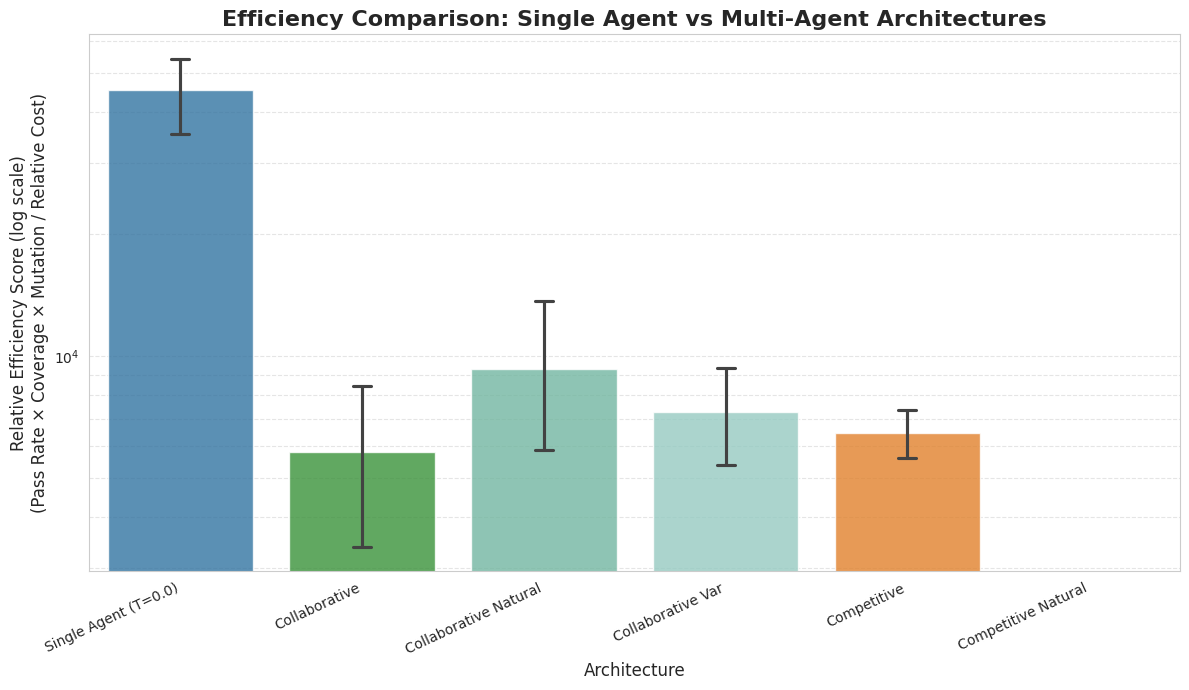


Efficiency Statistics:
                           mean       std  count
Category                                        
Collaborative           5789.25   7975.78     36
Collaborative Natural   9265.19   9763.38     20
Collaborative Var       7270.62   9404.07     89
Competitive             6470.47   6093.59    190
Single Agent (T=0.0)   45303.22  22894.25     19


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] == "success"]

# Filter experiments: collaborative, collaborative_var, competitive, and single llama8B T=0.0
df_filtered = df[
    df["experiment_name"].str.contains(
        "collaborative_llama8B|competitive_llama8B|ablative_single_llama8B_t=0.0",
        regex=True,
        na=False,
    )
].copy()

# Calculate Pass Rate
df_filtered["total_tests"] = (
    df_filtered["n_passed_tests"] + df_filtered["n_failed_tests"]
)
df_filtered["pass_rate"] = df_filtered.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] if row["total_tests"] > 0 else 0
    ),
    axis=1,
)

# File-Normalized Tokens (Relative Cost)
file_mean_tokens = df_filtered.groupby("file")["total_tokens"].transform("mean")
df_filtered["tokens_relative_cost"] = df_filtered["total_tokens"] / file_mean_tokens

# Relative Efficiency Score = (Quality / Cost)
# Quality = PassRate * Coverage * Mutation
# Cost = Normalized Tokens
df_filtered["efficiency"] = (
    df_filtered["pass_rate"]
    * df_filtered["coverage_percent"]
    * df_filtered["mutation_score_percent"]
    / df_filtered["tokens_relative_cost"]
)


# Create Category Labels
def categorize_experiment(exp_name):
    if (
        "ablative_single_llama8B_t=0.0" in exp_name
        or "single_llama8B_t=0.0" in exp_name
    ):
        return "Single Agent (T=0.0)"
    elif "collaborative_llama8B_natural" in exp_name:
        return "Collaborative Natural"
    elif (
        "collaborative_llama8B_json_var" in exp_name
        or "collaborative_llama8B_var" in exp_name
    ):
        return "Collaborative Var"
    elif "collaborative_llama8B_json" in exp_name or (
        "collaborative_llama8B" in exp_name
        and "_json" not in exp_name
        and "_natural" not in exp_name
        and "_var" not in exp_name
    ):
        return "Collaborative"
    elif "competitive_llama8B_natural" in exp_name:
        return "Competitive Natural"
    elif "competitive_llama8B_json" in exp_name or (
        "competitive_llama8B" in exp_name
        and "_json" not in exp_name
        and "_natural" not in exp_name
    ):
        return "Competitive"
    return "Other"


df_filtered["Category"] = df_filtered["experiment_name"].apply(categorize_experiment)

# Remove any "Other" category if present
df_filtered = df_filtered[df_filtered["Category"] != "Other"]

# Define Colors
COLORS = {
    "Single Agent (T=0.0)": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Collaborative Natural": "#66c2a5",
    "Collaborative Var": "#8dd3c7",
    "Competitive": "#ff7f0e",
    "Competitive Natural": "#ffbb78",
}

# Plotting
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

category_order = [
    "Single Agent (T=0.0)",
    "Collaborative",
    "Collaborative Natural",
    "Collaborative Var",
    "Competitive",
    "Competitive Natural",
]

ax = sns.barplot(
    data=df_filtered,
    x="Category",
    y="efficiency",
    order=category_order,
    palette=COLORS,
    errorbar=("ci", 95),  # 95% Confidence Interval
    capsize=0.1,
    alpha=0.8,
)

# Set logarithmic scale for y-axis
ax.set_yscale("log")

plt.title(
    "Efficiency Comparison: Single Agent vs Multi-Agent Architectures",
    fontsize=16,
    fontweight="bold",
)
plt.ylabel(
    "Relative Efficiency Score (log scale)\n(Pass Rate × Coverage × Mutation / Relative Cost)",
    fontsize=12,
)
plt.xlabel("Architecture", fontsize=12)
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5, which="both")
plt.tight_layout()
plt.show()

# Print efficiency statistics
print("\nEfficiency Statistics:")
print("=" * 80)
efficiency_summary = df_filtered.groupby("Category")["efficiency"].agg(
    ["mean", "std", "count"]
)
print(efficiency_summary.round(2))